In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-27 11:25:33.677906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and a saturated signal qc, then extracting their corresponding gene label
gene_dict_df = pd.read_csv("../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter='\t')
gene_list_passed_qc = gene_dict_df.query("qc_pass").dependency_column.tolist()

# create new training and testing dataframes that contain only the filtered genes
subset_train_df = train_df.filter(gene_list_passed_qc, axis=1)
subset_test_df = test_df.filter(gene_list_passed_qc, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 2732)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.044344,-1.318725,-2.020148,-0.554069,0.011276,-0.829771,-2.862801,-0.937871,-0.029335,-0.079737,...,-0.171958,-0.408107,-0.295392,-1.181492,-0.158178,0.011724,0.134771,-0.202173,-0.251086,-0.257935
1,-1.010345,-1.084419,-1.768553,-0.561297,-0.323891,-0.822472,-2.610682,-0.896614,-0.009458,-0.095426,...,-0.729691,-0.589988,-0.358002,-0.952563,0.049743,-0.022304,-0.315429,-0.437890,-0.758958,-0.282723
2,-0.264528,-1.164834,-1.780863,-0.491005,0.132880,-0.774631,-1.938029,-1.241575,-0.086820,-0.015274,...,-1.056200,-0.852987,-0.413210,-1.052634,0.117768,0.219654,-0.375627,-0.064497,-0.934184,-0.203839


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 2732)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.210754,-1.321157,-2.145946,-0.151770,-0.155471,-0.775024,-2.385527,-1.495634,-0.418926,-0.075728,...,-0.499942,-0.513059,-0.424530,-1.244153,0.015781,0.078829,-0.196167,-0.524460,-1.037056,-0.314540
1,-0.126822,-1.382013,-2.173479,-0.208718,0.161889,-0.884878,-2.025593,-1.293933,-0.018025,0.045924,...,-0.736620,-0.432284,-0.507320,-1.781393,0.026585,0.059345,0.072144,0.047436,-0.541746,-0.602892
2,-0.387433,-1.079072,-2.346600,-0.331100,-0.102896,-0.669190,-2.169554,-0.808801,0.114080,-0.072095,...,-0.607937,-0.741635,-0.450178,-1.243914,-0.092732,0.055465,-0.369650,-0.256188,-0.590345,-0.260363


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to 
# learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=49,
    batch_size=80,
    encoder_batch_norm=True,
    epochs=255, 
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-27 11:25:39.521975: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
# training the beta VAE
# ideally loss and val_loss are both small and similar in value
# if validation appears to start increasing after reaching values near the trainging curve, try lowering the epochs to finish prior to the start of overfitting
# a decreasing Kullback-Leibler divergence score suggests a better trained model
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/255
10/10 [==============================] - 2s 108ms/step - loss: 1846.0835 - recon: 1821.6603 - kl: 24.4234 - val_loss: 71268.9375 - val_recon: 59547.5039 - val_kl: 11721.4277
Epoch 2/255
10/10 [==============================] - 1s 119ms/step - loss: 950.6927 - recon: 926.0020 - kl: 24.6906 - val_loss: 68810.5938 - val_recon: 62119.5312 - val_kl: 6691.0586
Epoch 3/255
10/10 [==============================] - 1s 96ms/step - loss: 707.9972 - recon: 682.2091 - kl: 25.7880 - val_loss: 19972.5957 - val_recon: 17974.9824 - val_kl: 1997.6111
Epoch 4/255
10/10 [==============================] - 1s 113ms/step - loss: 566.2551 - recon: 540.2379 - kl: 26.0171 - val_loss: 29922.2656 - val_recon: 27616.3477 - val_kl: 2305.9209
Epoch 5/255
10/10 [==============================] - 1s 107ms/step - loss: 504.2241 - recon: 478.1175 - kl: 26.1065 - val_loss: 6545.2520 - val_recon: 5844.5215 - val_kl: 700.7306
Epoch 6/255
10/10 [==============================] - 1s 108ms/step - loss: 437.8768 - 

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

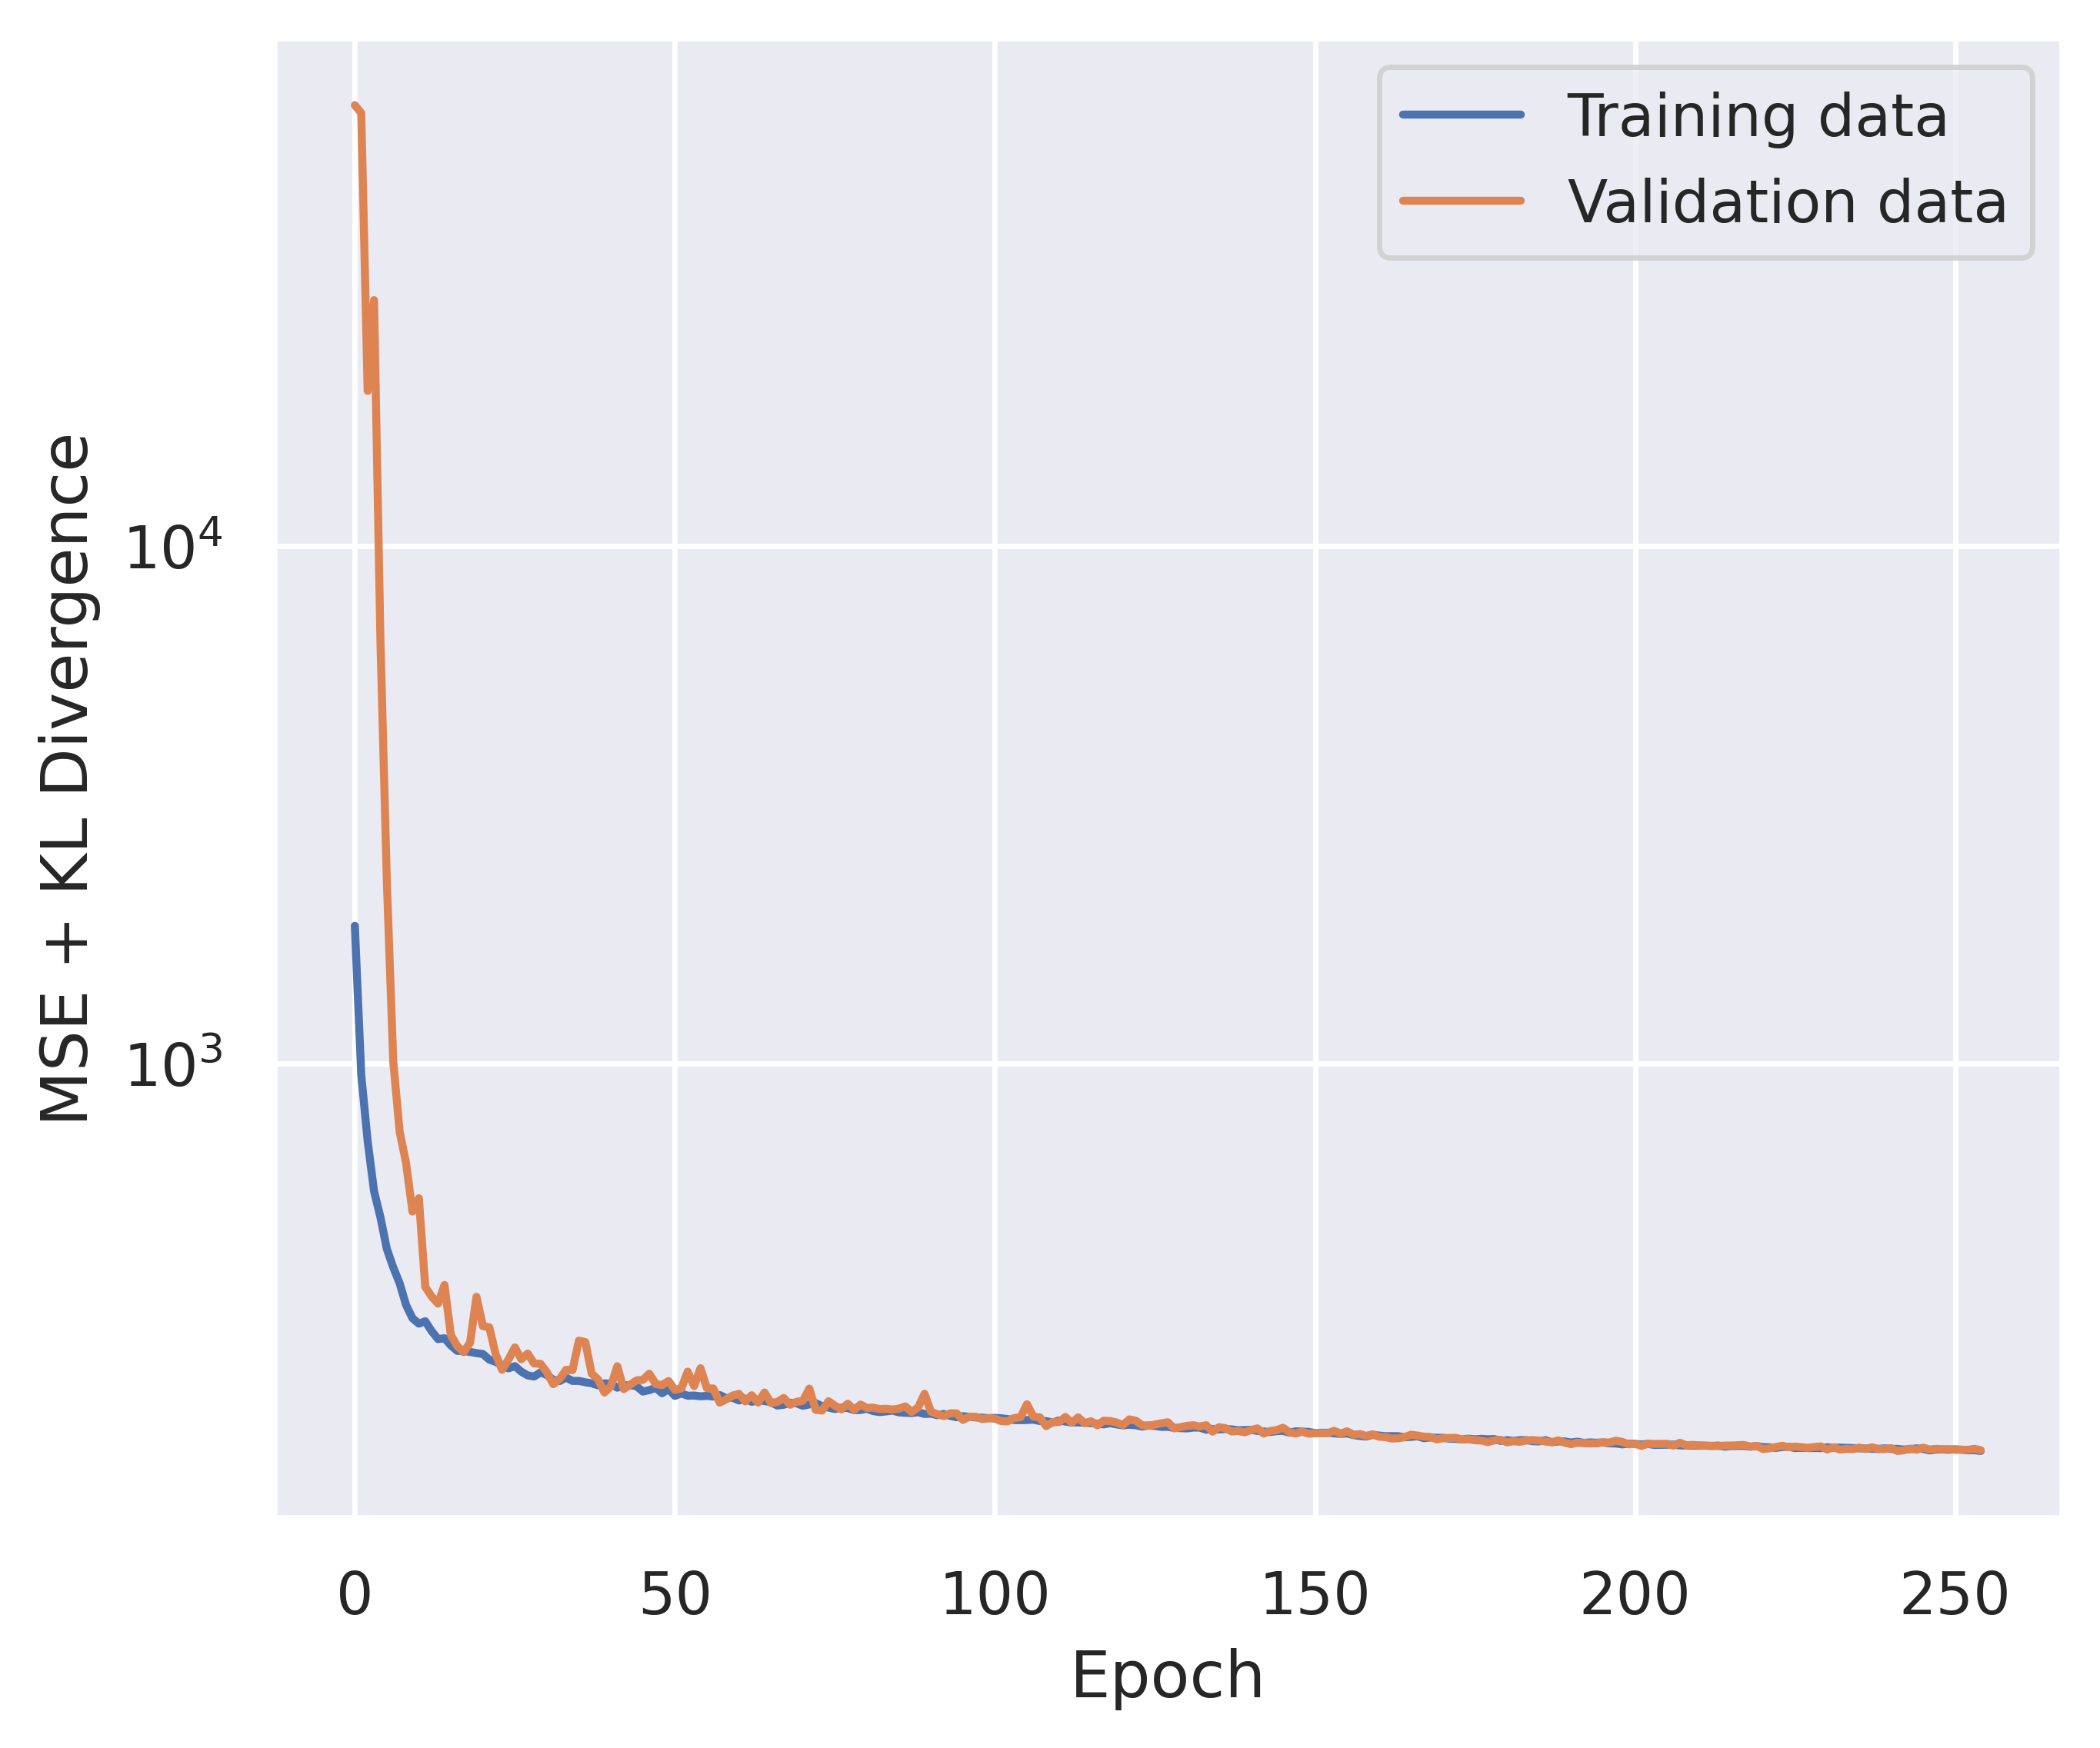

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene effect data with sex, AgeCategory, and ModelID for use in later t-tests
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list_passed_qc, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)

metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.csv")
metadata.to_csv(metadata_df_dir, index=False)
metadata


,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001549,Adult,Male,train
1,ACH-001992,Adult,Male,train
2,ACH-000035,Adult,Male,train
3,ACH-000911,Adult,Male,train
4,ACH-000259,Pediatric,Female,train
...,...,...,...,...
907,ACH-000858,Adult,Male,test
908,ACH-000514,Adult,Male,test
909,ACH-000258,Adult,Female,test
910,ACH-002446,Adult,Male,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 1s 34ms/step


,ModelID,0,1,2,3,4,5,6,7,8,...,39,40,41,42,43,44,45,46,47,48
0,ACH-001549,0.770663,-0.549157,3.272427,0.566686,-1.486665,0.159869,0.889582,1.580837,-0.117225,...,2.973020,1.915184,0.493111,1.111523,0.263324,0.769710,-0.086101,-0.768794,1.303094,0.310755
1,ACH-001992,0.096374,-0.050365,-0.552537,0.625854,0.279700,-0.311163,-0.501299,2.403682,0.620375,...,0.627633,0.346812,2.978342,-1.294521,0.783208,-0.074196,0.490011,-0.272740,-1.356594,0.506748
2,ACH-000035,1.288901,-0.706702,-1.537785,0.517040,-0.802465,0.035317,0.081034,1.719658,-0.696001,...,0.149666,1.048845,0.525381,1.301356,0.189475,1.039298,0.597261,-1.701137,-0.131737,1.178167
3,ACH-000911,-0.070980,0.314865,0.934309,0.493366,0.102961,0.122502,-0.826303,-0.109411,-0.845789,...,0.794017,0.286747,-1.250848,-0.015384,-0.600473,1.774456,-0.279023,-0.427222,-1.043919,-1.519210
4,ACH-000259,-0.955361,0.210109,0.473668,-0.839983,1.161763,-0.378171,-0.923595,1.949374,-0.167187,...,-1.157030,0.383896,0.609474,0.535174,-0.208617,-0.833482,1.100798,-0.020259,0.006875,-0.557194


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,-0.065762,-0.072253,0.047671,0.031671,0.099662,0.021346,0.065610,0.015976,0.035161,0.089890,...,-0.042195,0.013708,-0.099784,-0.084774,-0.037435,0.040306,0.020068,0.052680,0.046233,-0.010818
1,0.028984,-0.100351,0.015861,-0.041949,-0.070342,0.017694,-0.023452,0.054382,0.059402,-0.032064,...,0.026907,-0.022829,0.007821,0.028343,-0.053292,-0.011265,-0.035440,0.036614,-0.044030,-0.006800
2,0.045330,-0.053818,0.010939,-0.000805,-0.039995,0.021862,0.076901,-0.063818,-0.064618,-0.005598,...,-0.019090,-0.054465,-0.036813,-0.022718,-0.070924,0.020863,0.021782,-0.044477,-0.013088,-0.012784
3,-0.045774,0.007612,-0.011942,-0.046910,-0.053462,0.008274,-0.024193,-0.020667,-0.044887,0.003439,...,0.073001,0.001621,0.030357,-0.032754,0.058778,-0.000040,0.089375,0.011618,0.060612,-0.019115
4,0.008627,-0.056030,-0.037565,0.022606,-0.011073,-0.043281,-0.008081,-0.025632,-0.042584,-0.015704,...,-0.079438,-0.066371,0.027453,0.034278,0.135766,0.023697,0.035598,-0.086139,0.094295,-0.030740


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,AAAS,-0.065762,-0.072253,0.047671,0.031671,0.099662,0.021346,0.065610,0.015976,0.035161,...,-0.042195,0.013708,-0.099784,-0.084774,-0.037435,0.040306,0.020068,0.052680,0.046233,-0.010818
1,AAMP,0.028984,-0.100351,0.015861,-0.041949,-0.070342,0.017694,-0.023452,0.054382,0.059402,...,0.026907,-0.022829,0.007821,0.028343,-0.053292,-0.011265,-0.035440,0.036614,-0.044030,-0.006800
2,AARS1,0.045330,-0.053818,0.010939,-0.000805,-0.039995,0.021862,0.076901,-0.063818,-0.064618,...,-0.019090,-0.054465,-0.036813,-0.022718,-0.070924,0.020863,0.021782,-0.044477,-0.013088,-0.012784
3,AARS2,-0.045774,0.007612,-0.011942,-0.046910,-0.053462,0.008274,-0.024193,-0.020667,-0.044887,...,0.073001,0.001621,0.030357,-0.032754,0.058778,-0.000040,0.089375,0.011618,0.060612,-0.019115
4,AASDHPPT,0.008627,-0.056030,-0.037565,0.022606,-0.011073,-0.043281,-0.008081,-0.025632,-0.042584,...,-0.079438,-0.066371,0.027453,0.034278,0.135766,0.023697,0.035598,-0.086139,0.094295,-0.030740
